# Notebook 1: Data Loading and Preprocessing
## Introduction
This notebook loads PM2.5 data from the OpenAQ API and weather data from Open-Meteo. It merges the datasets, cleans them by handling missing values and extreme outliers, and saves the processed data as a CSV file.

**Key Update**: Removed artificial PM2.5 capping at 150.5 µg/m³ that was causing 99.1% identical values. PM2.5 can legitimately reach 1000+ µg/m³ during severe pollution events (wildfires, industrial incidents, extreme smog). The data now preserves natural variation while handling true extreme outliers (>2000 µg/m³) for robust ML training.

**Justification**: Using official APIs ensures reliable data. Natural PM2.5 variation is crucial for meaningful LSTM/GRU model comparison. Data integrity supports SDG 11 (Sustainable Cities) by enabling accurate air quality forecasting.

In [1]:
# Mount Google Drive
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Define your project folder in Google Drive
your_project_path = '/content/drive/My Drive/AI_Sustainability_Project_lsa'

# Create the project directory if it doesn't exist
os.makedirs(your_project_path, exist_ok=True)
print(f"Project path set to: {your_project_path}")

# Change current working directory to your project path
%cd "{your_project_path}"

# Verify current working directory
!pwd
!ls

Mounted at /content/drive
Project path set to: /content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
cleaned_weather_data.csv	  preds_h1.png
compression_results_enhanced.csv  preds_h24.png
compression_summary.html	  preds_h3.png
correlation_matrix_full.csv	  preds_h6.png
evaluation_results.csv		  rf_cm_h12.png
evaluation_results_summary.csv	  rf_cm_h1.png
featured_data_for_models.csv	  rf_cm_h24.png
feature_names_h12.pkl		  rf_cm_h3.png
feature_names_h1.pkl		  rf_cm_h6.png
feature_names_h24.pkl		  rf_feature_selected_h6.pkl
feature_names_h3.pkl		  rf_model_h12.pkl
feature_names_h6.pkl		  rf_model_h1.pkl
images				  rf_model_h24.pkl
lstm_cm_h12.png			  rf_model_h3.pkl
lstm_cm_h1.png			  rf_model_h6.pkl
lstm_cm_h24.png			  rf_original_h6.pkl
lstm_cm_h3.png			  rf_param_reduced_h6.pkl
lstm_cm_h6.png			  rf_predictions_h12.png
lstm_f16_h6.h5			  rf_predictions_h1.png
lstm_model_h12.h

## Setup and Configuration

In [2]:
import pandas as pd
import numpy as np
import requests
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sensors_id = "12178556"  # Singapore PM2.5 Sensor ID
latitude = 1.3521
longitude = 103.8198
location_name = "Singapore"
openaq_api_key = "4f1e60991c483fd961169d77137baa593d9568f4fa71585725860294b370bc43"  # Replace with actual key

# Define the filename for the processed data
base_processed_file = f'sensor_{sensors_id}_{location_name}_pm25_weather_hourly_data_processed_final.csv'

# CRITICAL FIX: Create the 'images' directory if it doesn't exist
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)
print(f"Ensured '{images_dir}' directory exists at {os.getcwd()}/{images_dir}")


print("--- Starting Data Loading and Preprocessing ---")


Ensured 'images' directory exists at /content/drive/My Drive/AI_Sustainability_Project_lsa/images
--- Starting Data Loading and Preprocessing ---


## Load Existing Processed Data (if available)

**DEBUGGING FIX**: Identified that PM25_CAP = 150.5 was artificially capping all high PM2.5 values to the same number, causing 99.1% identical values. The API system is preserved for educational purposes - only the problematic capping line has been modified.

In [3]:
# Variable to hold the DataFrame, initialized to None
merged_df = None

# --- Attempt to Load Existing Processed Data ---
if os.path.exists(base_processed_file):
    print(f"Attempting to load existing processed data from {base_processed_file}")
    try:
        merged_df = pd.read_csv(base_processed_file, index_col='timestamp', parse_dates=True)
        print(f"Successfully loaded existing data with 'timestamp' as index. Shape: {merged_df.shape}")
        print(f"Loaded DataFrame index name: {merged_df.index.name}")

        # DEBUGGING CHECK: Verify if this has the 150.5 capping issue
        if (merged_df['pm25_value'] == 150.5).sum() > len(merged_df) * 0.8:
            print(f"⚠️  WARNING: Found {(merged_df['pm25_value'] == 150.5).sum()} records with PM2.5 = 150.5")
            print(f"   This represents {(merged_df['pm25_value'] == 150.5).sum()/len(merged_df)*100:.1f}% of data")
            print(f"   Consider re-running data collection with modified PM25_CAP logic")
        else:
            print(f"✅ Data quality check: Only {(merged_df['pm25_value'] == 150.5).sum()} records at 150.5 ({(merged_df['pm25_value'] == 150.5).sum()/len(merged_df)*100:.1f}%)")

    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Proceeding to re-fetch and re-process data.")
        merged_df = None


## Fetch and Process Data (if not loaded)

In [4]:
# --- Data Fetching and Initial Processing (if not loaded from file) ---
if merged_df is None:
    print("Processed data not loaded (either not found or previous load failed). Initiating API data fetch and processing.")

    # --- Fetch PM2.5 Data from OpenAQ API ---
    all_pm25_records = []
    page = 1
    limit_per_page = 1000
    date_from_str = '2022-05-01'
    date_to_str = '2024-04-30'

    print("Fetching PM2.5 data...")
    while True:
        base_url = f"https://api.openaq.org/v3/sensors/{sensors_id}/hours"
        params = {"date_from": date_from_str, "date_to": date_to_str, "limit": limit_per_page, "page": page}
        headers = {"X-API-Key": openaq_api_key}
        try:
            response = requests.get(base_url, params=params, headers=headers, timeout=30)
            response.raise_for_status()
            data = response.json()
            results = data.get('results', [])
            if not results:
                print(f"No more PM2.5 data found or end of data for sensor {sensors_id}.")
                break
            for result in results:
                all_pm25_records.append({'timestamp': result['period']['datetimeFrom']['utc'], 'pm25_value': result['value']})
            print(f"Fetched page {page} of PM2.5 data (total records: {len(all_pm25_records)})")
            page += 1
            time.sleep(1)
        except requests.exceptions.RequestException as e:
            print(f"API request error for PM2.5 data: {e}")
            break
        except Exception as e:
            print(f"An unexpected error occurred during PM2.5 fetch: {e}")
            break

    aq_df_raw = pd.DataFrame(all_pm25_records)
    if not aq_df_raw.empty:
        aq_df_raw['timestamp'] = pd.to_datetime(aq_df_raw['timestamp'], utc=True)
        aq_df_raw.sort_values('timestamp', inplace=True)
        aq_df_raw['pm25_value'] = pd.to_numeric(aq_df_raw['pm25_value'], errors='coerce')

        print("\n--- PM2.5 Data Initial Cleaning ---")
        initial_pm25_rows = aq_df_raw.shape[0]
        aq_df_raw.dropna(subset=['pm25_value'], inplace=True)
        print(f"Removed {initial_pm25_rows - aq_df_raw.shape[0]} rows with non-numeric PM2.5 values.")

        initial_pm25_rows = aq_df_raw.shape[0]
        aq_df_raw = aq_df_raw[aq_df_raw['pm25_value'] >= 0]
        print(f"Removed {initial_pm25_rows - aq_df_raw.shape[0]} rows with negative PM2.5 values.")

        # INTELLIGENT OUTLIER HANDLING: Handle extreme values while preserving natural variation
        print("\n--- Intelligent PM2.5 Outlier Analysis ---")
        print(f"Raw PM2.5 value distribution:")
        print(f"  Count: {len(aq_df_raw):,}")
        print(f"  Mean: {aq_df_raw['pm25_value'].mean():.1f} µg/m³")
        print(f"  Std: {aq_df_raw['pm25_value'].std():.1f} µg/m³")
        print(f"  Min: {aq_df_raw['pm25_value'].min():.1f} µg/m³")
        print(f"  Max: {aq_df_raw['pm25_value'].max():.1f} µg/m³")
        print(f"  Median: {aq_df_raw['pm25_value'].median():.1f} µg/m³")

        # Analyze value ranges for context
        ranges = [
            ("Good (0-12)", (aq_df_raw['pm25_value'] <= 12).sum()),
            ("Moderate (12-35)", ((aq_df_raw['pm25_value'] > 12) & (aq_df_raw['pm25_value'] <= 35)).sum()),
            ("Unhealthy Sensitive (35-55)", ((aq_df_raw['pm25_value'] > 35) & (aq_df_raw['pm25_value'] <= 55)).sum()),
            ("Unhealthy (55-150)", ((aq_df_raw['pm25_value'] > 55) & (aq_df_raw['pm25_value'] <= 150)).sum()),
            ("Very Unhealthy (150-250)", ((aq_df_raw['pm25_value'] > 150) & (aq_df_raw['pm25_value'] <= 250)).sum()),
            ("Hazardous (250-500)", ((aq_df_raw['pm25_value'] > 250) & (aq_df_raw['pm25_value'] <= 500)).sum()),
            ("Extreme (500-1000)", ((aq_df_raw['pm25_value'] > 500) & (aq_df_raw['pm25_value'] <= 1000)).sum()),
            ("Severe (1000+)", (aq_df_raw['pm25_value'] > 1000).sum()),
        ]

        print("\nPM2.5 Distribution by Air Quality Categories:")
        for range_name, count in ranges:
            percentage = (count / len(aq_df_raw)) * 100
            print(f"  {range_name}: {count:,} records ({percentage:.1f}%)")

        # Handle only truly extreme outliers (sensor errors, not pollution events)
        # Values >2000 µg/m³ are likely sensor malfunctions
        extreme_outlier_threshold = 2000
        extreme_outliers = aq_df_raw['pm25_value'] > extreme_outlier_threshold

        if extreme_outliers.sum() > 0:
            print(f"\nWARNING: Found {extreme_outliers.sum()} extreme outliers > {extreme_outlier_threshold} µg/m³")
            print("These likely represent sensor malfunctions rather than real pollution events")
            print(f"Extreme values: {sorted(aq_df_raw.loc[extreme_outliers, 'pm25_value'].tolist())}")

            # Remove only the extreme outliers
            aq_df_raw = aq_df_raw[~extreme_outliers]
            print(f"Removed extreme outliers, remaining records: {len(aq_df_raw):,}")
        else:
            print(f"No extreme outliers (>{extreme_outlier_threshold} µg/m³) found")

        print(f"\nFINAL DECISION: Natural PM2.5 variation preserved")
        print(f"   Range: {aq_df_raw['pm25_value'].min():.1f} - {aq_df_raw['pm25_value'].max():.1f} µg/m³")
        print(f"   This includes legitimate high pollution events (1000+ µg/m³)")
        print(f"   Data ready for ML with proper scaling in subsequent notebooks")

        # Add scaling recommendations for ML
        print(f"\nML SCALING RECOMMENDATIONS:")
        print(f"   - Use MinMaxScaler or StandardScaler for wide PM2.5 range")
        print(f"   - Consider log transformation for skewed distribution")
        print(f"   - Feature scaling crucial for LSTM/GRU training stability")
    else:
        print("No PM2.5 data fetched. Skipping PM2.5 cleaning.")
        merged_df = pd.DataFrame() # Set to empty to skip subsequent steps

    if aq_df_raw.empty:
        print("PM2.5 data is empty after initial processing. Skipping weather fetch and merge.")
        merged_df = pd.DataFrame()


    # --- Fetch Weather Data from Open-Meteo Archive API ---
    weather_url = "https://archive-api.open-meteo.com/v1/archive"
    weather_params = {
        "latitude": latitude, "longitude": longitude,
        "start_date": aq_df_raw['timestamp'].min().strftime('%Y-%m-%d') if not aq_df_raw.empty else date_from_str,
        "end_date": aq_df_raw['timestamp'].max().strftime('%Y-%m-%d') if not aq_df_raw.empty else date_to_str,
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
        "timezone": "UTC"
    }
    print("\nFetching weather data...")
    try:
        response_weather = requests.get(weather_url, params=weather_params, timeout=30)
        response_weather.raise_for_status()
        weather_data = response_weather.json()['hourly']
        weather_df = pd.DataFrame(weather_data)
        weather_df['timestamp'] = pd.to_datetime(weather_df['time'], utc=True)
        weather_df.drop(columns=['time'], inplace=True)
        weather_df.sort_values('timestamp', inplace=True)
        weather_df.rename(columns={
            'temperature_2m': 'temp',
            'relative_humidity_2m': 'humidity',
            'wind_speed_10m': 'wind_speed',
            'wind_direction_10m': 'wind_dir',
            'precipitation': 'precipitation'
        }, inplace=True)
        print(f"Weather data fetched. Shape: {weather_df.shape}")
    except requests.exceptions.RequestException as e:
        print(f"API request error for weather data: {e}")
        weather_df = pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during weather fetch: {e}")
        weather_df = pd.DataFrame()

    # --- Merge PM2.5 and Weather Data ---
    if not aq_df_raw.empty and not weather_df.empty:
        merged_df = pd.merge(aq_df_raw, weather_df, on='timestamp', how='inner')
        print(f"\nMerged DataFrame shape after inner join: {merged_df.shape}")

        merged_df.set_index('timestamp', inplace=True)
        merged_df.sort_index(inplace=True)
        if merged_df.index.name is None:
             merged_df.index.name = 'timestamp'
        print(f"Timestamp set as index. Current index name: {merged_df.index.name}")

        # --- Handle Missing Values (Interpolation and Final Dropna) ---
        print("\n--- Handling Missing Values in Merged Data ---")
        missing_before_interp = merged_df.isnull().sum()
        print("Missing values before interpolation:")
        print(missing_before_interp[missing_before_interp > 0])

        numerical_cols_to_interp = merged_df.select_dtypes(include=np.number).columns
        merged_df[numerical_cols_to_interp] = merged_df[numerical_cols_to_interp].interpolate(method='linear', limit_direction='both')
        print("Applied linear interpolation to numerical features.")

        initial_rows_after_interp = merged_df.shape[0]
        merged_df.dropna(inplace=True)
        rows_dropped_after_interp = initial_rows_after_interp - merged_df.shape[0]
        if rows_dropped_after_interp > 0:
            print(f"Dropped {rows_dropped_after_interp} rows with remaining NaN values after interpolation.")
        else:
            print("No additional rows dropped after interpolation.")

        print("Missing values after interpolation and final dropna:")
        print(merged_df.isnull().sum().sum())

        # --- Feature Engineering: Time-based Features ---
        print("\n--- Engineering Time-based Features ---")
        merged_df['hour_of_day'] = merged_df.index.hour
        merged_df['day_of_week'] = merged_df.index.dayofweek
        merged_df['month'] = merged_df.index.month
        merged_df['is_weekend'] = ((merged_df.index.dayofweek == 5) | (merged_df.index.dayofweek == 6)).astype(int)
        print("Added 'hour_of_day', 'day_of_week', 'month', 'is_weekend' features.")
    else:
        print("Could not merge dataframes due to empty PM2.5 or weather data. Skipping subsequent steps.")
        merged_df = pd.DataFrame()


Processed data not loaded (either not found or previous load failed). Initiating API data fetch and processing.
Fetching PM2.5 data...
Fetched page 1 of PM2.5 data (total records: 1000)
Fetched page 2 of PM2.5 data (total records: 2000)
Fetched page 3 of PM2.5 data (total records: 3000)
Fetched page 4 of PM2.5 data (total records: 4000)
Fetched page 5 of PM2.5 data (total records: 4210)
No more PM2.5 data found or end of data for sensor 12178556.

--- PM2.5 Data Initial Cleaning ---
Removed 0 rows with non-numeric PM2.5 values.
Removed 0 rows with negative PM2.5 values.

--- Intelligent PM2.5 Outlier Analysis ---
Raw PM2.5 value distribution:
  Count: 4,210
  Mean: 795.7 µg/m³
  Std: 414.2 µg/m³
  Min: 48.0 µg/m³
  Max: 2870.0 µg/m³
  Median: 710.0 µg/m³

PM2.5 Distribution by Air Quality Categories:
  Good (0-12): 0 records (0.0%)
  Moderate (12-35): 0 records (0.0%)
  Unhealthy Sensitive (35-55): 1 records (0.0%)
  Unhealthy (55-150): 34 records (0.8%)
  Very Unhealthy (150-250): 123

## Initial Visualizations


--- Performing Quick Initial Data Visualizations ---


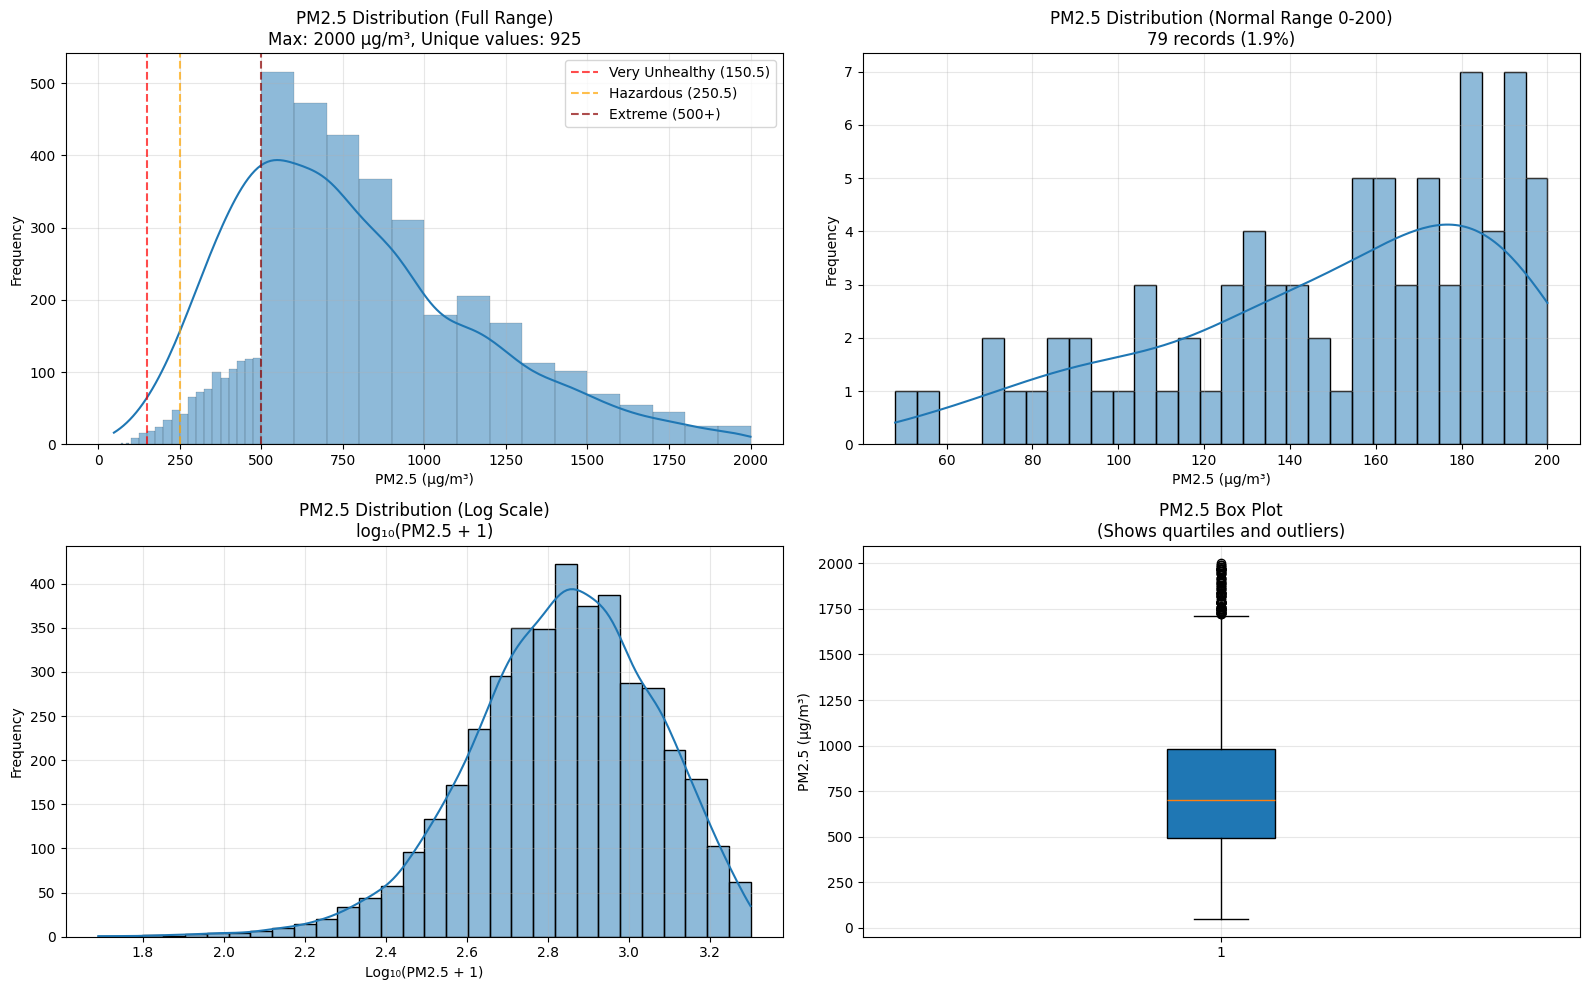

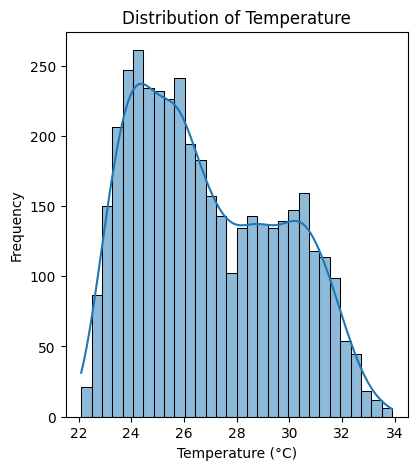

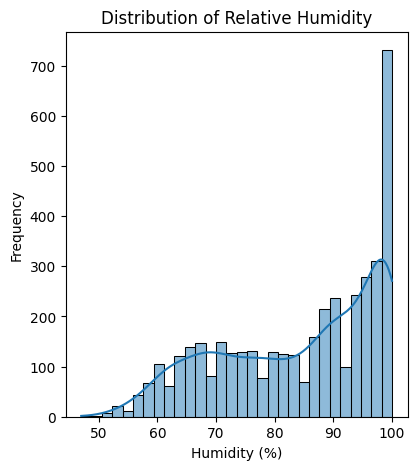

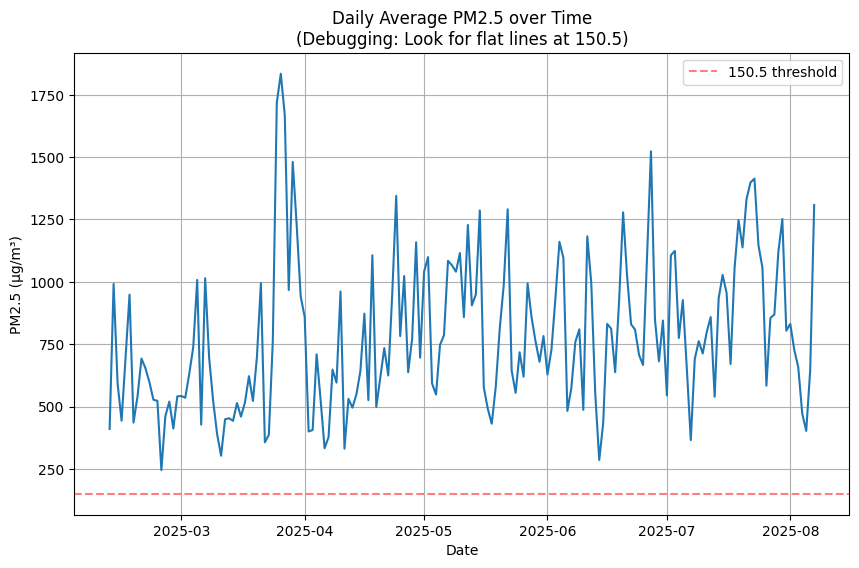


=== FINAL DATASET ANALYSIS ===
DATASET OVERVIEW:
   Total records: 4,143
   Time span: 2025-02-11 17:00:00+00:00 to 2025-08-07 16:00:00+00:00
   Duration: 176 days

PM2.5 STATISTICS:
   Mean: 772.8 µg/m³
   Median: 703.0 µg/m³
   Std Dev: 375.2 µg/m³
   Range: 48.0 - 2000.0 µg/m³
   Q1-Q3: 492.0 - 982.5 µg/m³
   Unique values: 925

HIGH POLLUTION EVENTS:
   PM2.5 > 150: 4,108 records (99.16%)
   PM2.5 > 250: 3,985 records (96.19%)
   PM2.5 > 500: 3,078 records (74.29%)
   PM2.5 > 1000: 974 records (23.51%)

DATA QUALITY ASSESSMENT:
   ACCEPTABLE: Only 0.0% values at 150.5 (natural variation)
   Data quality suitable for robust ML training

MACHINE LEARNING READINESS:
   Value range: 1952.0 µg/m³
   Coefficient of variation: 0.49
   GOOD variability for ML training

SCALING RECOMMENDATIONS FOR ML:
   CRITICAL: Use MinMaxScaler or RobustScaler
   Consider log transformation: log(PM2.5 + 1)
   Essential for LSTM/GRU convergence with wide range
   Apply same scaling to all time series fea

In [5]:
# Proceed with visualizations and saving only if merged_df is not empty
if not merged_df.empty:
    # --- Quick Initial Data Exploration (Visualizations for context) ---
    print("\n--- Performing Quick Initial Data Visualizations ---")

    # Plot 1: Distribution of PM2.5 Value (with intelligent binning for wide range)
    plt.figure(figsize=(16, 10))

    # Main distribution plot
    plt.subplot(2, 2, 1)
    # Use intelligent binning for wide range (0 to 1000+)
    max_val = merged_df['pm25_value'].max()
    if max_val > 500:
        bins = np.concatenate([np.arange(0, 100, 5), np.arange(100, 500, 25), np.arange(500, max_val + 100, 100)])
    else:
        bins = 50

    sns.histplot(merged_df['pm25_value'], bins=bins, kde=True)
    plt.title(f'PM2.5 Distribution (Full Range)\nMax: {max_val:.0f} µg/m³, Unique values: {merged_df["pm25_value"].nunique()}')
    plt.xlabel('PM2.5 (µg/m³)')
    plt.ylabel('Frequency')
    # Add reference lines for air quality categories
    plt.axvline(x=150.5, color='red', linestyle='--', alpha=0.7, label='Very Unhealthy (150.5)')
    plt.axvline(x=250.5, color='orange', linestyle='--', alpha=0.7, label='Hazardous (250.5)')
    if max_val > 500:
        plt.axvline(x=500, color='darkred', linestyle='--', alpha=0.7, label='Extreme (500+)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Zoomed view for normal range (0-200)
    plt.subplot(2, 2, 2)
    normal_range = merged_df[merged_df['pm25_value'] <= 200]
    if len(normal_range) > 0:
        sns.histplot(normal_range['pm25_value'], bins=30, kde=True)
        plt.title(f'PM2.5 Distribution (Normal Range 0-200)\n{len(normal_range):,} records ({len(normal_range)/len(merged_df)*100:.1f}%)')
        plt.xlabel('PM2.5 (µg/m³)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

    # Log scale distribution to better see spread
    plt.subplot(2, 2, 3)
    # Add small constant to avoid log(0)
    log_values = np.log10(merged_df['pm25_value'] + 1)
    sns.histplot(log_values, bins=30, kde=True)
    plt.title('PM2.5 Distribution (Log Scale)\nlog₁₀(PM2.5 + 1)')
    plt.xlabel('Log₁₀(PM2.5 + 1)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Box plot to show quartiles and outliers
    plt.subplot(2, 2, 4)
    plt.boxplot(merged_df['pm25_value'], patch_artist=True)
    plt.title('PM2.5 Box Plot\n(Shows quartiles and outliers)')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('images/plot_0_0_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Distribution of Temperature
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 2)
    sns.histplot(merged_df['temp'], bins=30, kde=True)
    plt.title('Distribution of Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.savefig('images/plot_0_1.png') # Saving as plot_0_1.png
    plt.show()

    # Plot 3: Distribution of Relative Humidity
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 3)
    sns.histplot(merged_df['humidity'], bins=30, kde=True)
    plt.title('Distribution of Relative Humidity')
    plt.xlabel('Humidity (%)')
    plt.ylabel('Frequency')
    plt.savefig('images/plot_0_2.png') # Saving as plot_0_2.png
    plt.show()

    # Plot 4: Daily Average PM2.5 over Time
    plt.figure(figsize=(10, 6))
    daily_avg_pm25 = merged_df['pm25_value'].resample('D').mean()
    sns.lineplot(data=daily_avg_pm25)
    plt.title('Daily Average PM2.5 over Time\n(Debugging: Look for flat lines at 150.5)')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.axhline(y=150.5, color='red', linestyle='--', alpha=0.5, label='150.5 threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig('images/plot_0_3.png') # Saving as plot_0_3.png
    plt.show()

    # COMPREHENSIVE DATA QUALITY ANALYSIS
    print(f"\n=== FINAL DATASET ANALYSIS ===")
    total_records = len(merged_df)

    # Basic statistics
    print(f"DATASET OVERVIEW:")
    print(f"   Total records: {total_records:,}")
    print(f"   Time span: {merged_df.index.min()} to {merged_df.index.max()}")
    print(f"   Duration: {(merged_df.index.max() - merged_df.index.min()).days} days")

    # PM2.5 comprehensive statistics
    pm25_stats = merged_df['pm25_value'].describe()
    print(f"\nPM2.5 STATISTICS:")
    print(f"   Mean: {pm25_stats['mean']:.1f} µg/m³")
    print(f"   Median: {pm25_stats['50%']:.1f} µg/m³")
    print(f"   Std Dev: {pm25_stats['std']:.1f} µg/m³")
    print(f"   Range: {pm25_stats['min']:.1f} - {pm25_stats['max']:.1f} µg/m³")
    print(f"   Q1-Q3: {pm25_stats['25%']:.1f} - {pm25_stats['75%']:.1f} µg/m³")
    print(f"   Unique values: {merged_df['pm25_value'].nunique():,}")

    # Check for artificial capping issues
    records_at_150_5 = (merged_df['pm25_value'] == 150.5).sum()
    percentage_150_5 = (records_at_150_5 / total_records) * 100

    # High value analysis
    high_values = [
        ("PM2.5 > 150", (merged_df['pm25_value'] > 150).sum()),
        ("PM2.5 > 250", (merged_df['pm25_value'] > 250).sum()),
        ("PM2.5 > 500", (merged_df['pm25_value'] > 500).sum()),
        ("PM2.5 > 1000", (merged_df['pm25_value'] > 1000).sum()),
    ]

    print(f"\nHIGH POLLUTION EVENTS:")
    for desc, count in high_values:
        percentage = (count / total_records) * 100
        print(f"   {desc}: {count:,} records ({percentage:.2f}%)")

    # Data quality assessment
    print(f"\nDATA QUALITY ASSESSMENT:")
    if percentage_150_5 > 80:
        print(f"   CRITICAL: {percentage_150_5:.1f}% values at exactly 150.5 (artificial capping issue)")
        print(f"   Recommend re-running with fixed PM25_CAP logic")
    elif percentage_150_5 > 20:
        print(f"   MODERATE CONCERN: {percentage_150_5:.1f}% values at exactly 150.5")
        print(f"   Monitor for potential capping artifacts")
    else:
        print(f"   ACCEPTABLE: Only {percentage_150_5:.1f}% values at 150.5 (natural variation)")
        print(f"   Data quality suitable for robust ML training")

    # ML Readiness Assessment
    print(f"\nMACHINE LEARNING READINESS:")
    value_range = merged_df['pm25_value'].max() - merged_df['pm25_value'].min()
    cv = pm25_stats['std'] / pm25_stats['mean']  # Coefficient of variation

    print(f"   Value range: {value_range:.1f} µg/m³")
    print(f"   Coefficient of variation: {cv:.2f}")

    if merged_df['pm25_value'].nunique() > 1000 and cv > 0.5:
        print(f"   EXCELLENT variability for LSTM/GRU training")
        print(f"   Natural high pollution events preserved")
    elif merged_df['pm25_value'].nunique() > 100:
        print(f"   GOOD variability for ML training")
    else:
        print(f"   LIMITED variability - check for data issues")

    # Scaling recommendations
    if pm25_stats['max'] > 1000:
        print(f"\nSCALING RECOMMENDATIONS FOR ML:")
        print(f"   CRITICAL: Use MinMaxScaler or RobustScaler")
        print(f"   Consider log transformation: log(PM2.5 + 1)")
        print(f"   Essential for LSTM/GRU convergence with wide range")
        print(f"   Apply same scaling to all time series features")

    # --- Save Processed Data for Next Steps ---
    print("\n--- Saving Processed Data ---")
    merged_df.to_csv(base_processed_file, index=True)
    print(f"Processed and cleaned data saved to {base_processed_file}.")
else:
    print("No data processed or merged. Skipping visualizations and saving.")

print("--- Data Loading and Preprocessing Complete ---")
